# Amazon Sales Dataset - Descriptive Statistics
Deep-dive statistical analysis with hypothesis testing and distribution analysis


## Cell 1: Setup and Data Loading

This notebook performs advanced statistical analysis on Amazon sales data including:
- Distribution analysis and normality testing
- Outlier detection and treatment
- Hypothesis testing (t-tests, chi-square)
- Confidence intervals
- Advanced statistical metrics

In [8]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest, skew, kurtosis, chi2_contingency, ttest_ind, f_oneway
import os
import warnings
import matplotlib.dates as mdates
warnings.filterwarnings('ignore')

# Configure visualization
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Load data from PostgreSQL
DATABASE_URL = os.getenv('DATABASE_URL')
engine = create_engine(DATABASE_URL)
df = pd.read_sql("SELECT * FROM sales_transactions", engine)
df['orderdate'] = pd.to_datetime(df['orderdate'])

print("="*80)
print("DESCRIPTIVE STATISTICS ANALYSIS")
print("="*80)
print(f"\nDataset loaded: {len(df):,} transactions")
print(f"Date range: {df['orderdate'].min().date()} to {df['orderdate'].max().date()}")


DESCRIPTIVE STATISTICS ANALYSIS

Dataset loaded: 100,000 transactions
Date range: 2020-01-01 to 2024-12-29


# ============================================================================
# Section 1: Distribution Analysis
# ============================================================================



1.1 Order Value Distribution Analysis
--------------------------------------------------------------------------------
Mean: $918.26
Median: $714.32
Mode: $79.61
Standard Deviation: $724.51
Variance: $524,912.32
Coefficient of Variation: 78.90%

Skewness: 0.945
  → Right-skewed (positive): Long tail on the right, mean > median

Kurtosis: 0.178
  → Leptokurtic: Heavy tails, more outliers than normal distribution

Normality Test (D'Agostino-Pearson):
  Statistic: 10972.4972
  P-value: 0.0000
  → Distribution is NOT normal (reject null hypothesis)

1.2 Percentile Analysis
--------------------------------------------------------------------------------
1th percentile: $27.20
5th percentile: $83.09
10th percentile: $148.27
25th percentile: $340.89
50th percentile: $714.32
75th percentile: $1,349.76
90th percentile: $2,009.17
95th percentile: $2,383.64
99th percentile: $2,947.81


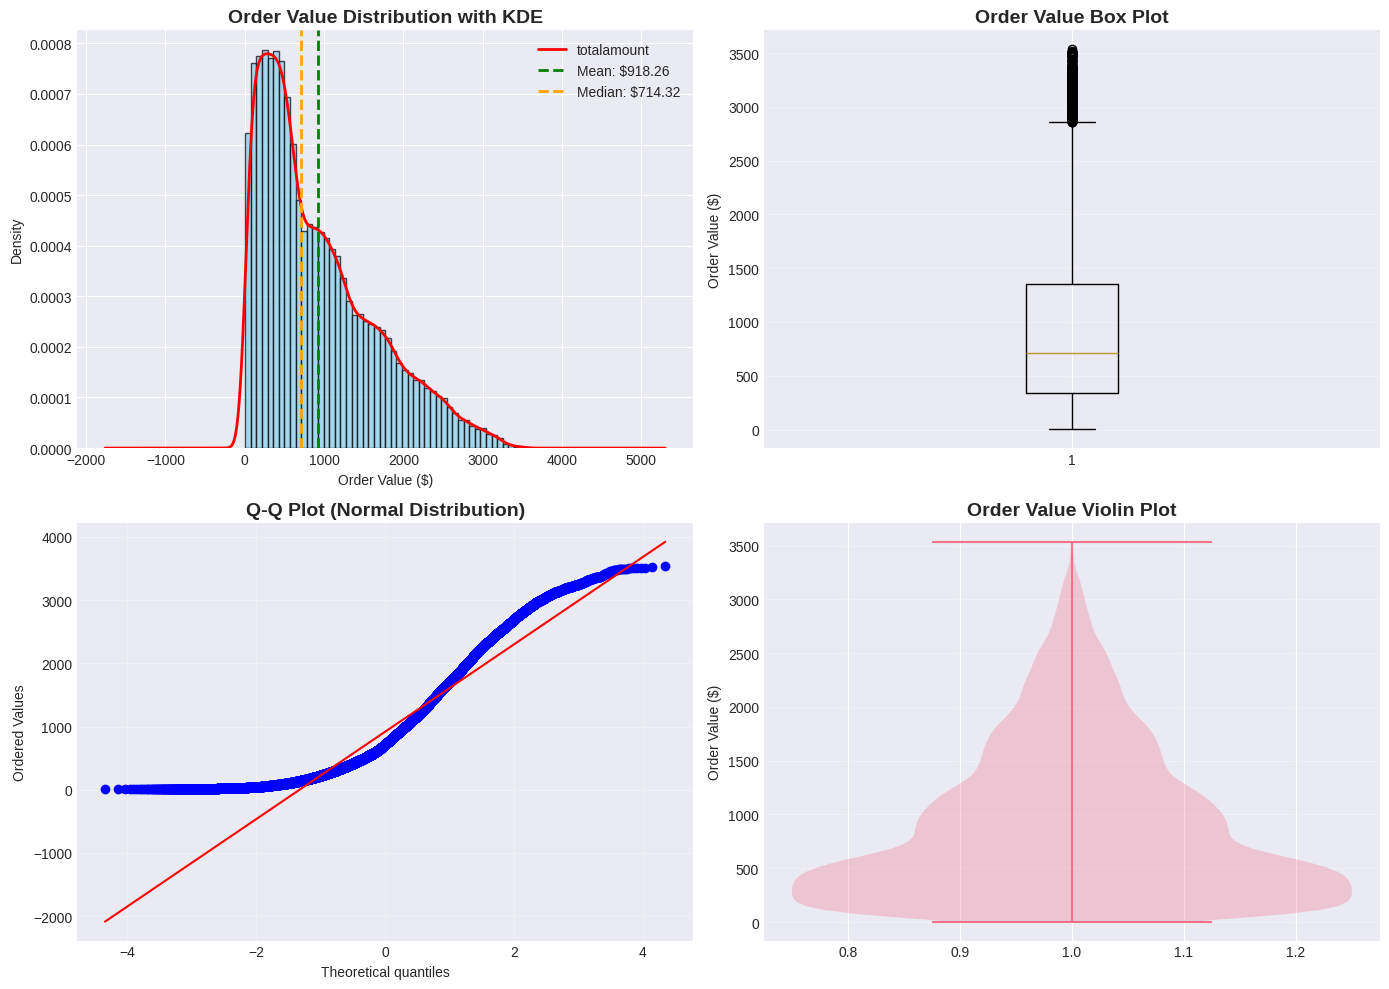

In [9]:
# Analyze distribution of total amount
print("\n1.1 Order Value Distribution Analysis")
print("-"*80)

order_values = df['totalamount']

# Calculate distribution metrics
mean_val = order_values.mean()
median_val = order_values.median()
mode_val = order_values.mode()[0]
std_val = order_values.std()
variance_val = order_values.var()
skewness = skew(order_values)
kurt = kurtosis(order_values)

print(f"Mean: ${mean_val:,.2f}")
print(f"Median: ${median_val:,.2f}")
print(f"Mode: ${mode_val:,.2f}")
print(f"Standard Deviation: ${std_val:,.2f}")
print(f"Variance: ${variance_val:,.2f}")
print(f"Coefficient of Variation: {(std_val/mean_val)*100:.2f}%")
print(f"\nSkewness: {skewness:.3f}")
if skewness > 0:
    print("  → Right-skewed (positive): Long tail on the right, mean > median")
elif skewness < 0:
    print("  → Left-skewed (negative): Long tail on the left, mean < median")
else:
    print("  → Symmetric distribution")

print(f"\nKurtosis: {kurt:.3f}")
if kurt > 0:
    print("  → Leptokurtic: Heavy tails, more outliers than normal distribution")
elif kurt < 0:
    print("  → Platykurtic: Light tails, fewer outliers than normal distribution")
else:
    print("  → Mesokurtic: Similar to normal distribution")

# Test for normality
stat, p_value = normaltest(order_values)
print(f"\nNormality Test (D'Agostino-Pearson):")
print(f"  Statistic: {stat:.4f}")
print(f"  P-value: {p_value:.4f}")
if p_value < 0.05:
    print("  → Distribution is NOT normal (reject null hypothesis)")
else:
    print("  → Distribution appears normal (fail to reject null hypothesis)")

# Percentile analysis
print("\n1.2 Percentile Analysis")
print("-"*80)
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
percentile_values = np.percentile(order_values, percentiles)

for p, val in zip(percentiles, percentile_values):
    print(f"{p}th percentile: ${val:,.2f}")

# Visualize distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histogram with KDE
axes[0, 0].hist(order_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7, density=True)
order_values.plot(kind='kde', ax=axes[0, 0], color='red', linewidth=2)
axes[0, 0].axvline(mean_val, color='green', linestyle='--', linewidth=2, label=f'Mean: ${mean_val:.2f}')
axes[0, 0].axvline(median_val, color='orange', linestyle='--', linewidth=2, label=f'Median: ${median_val:.2f}')
axes[0, 0].set_title('Order Value Distribution with KDE', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Order Value ($)')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()

# Box plot
axes[0, 1].boxplot(order_values, vert=True)
axes[0, 1].set_title('Order Value Box Plot', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Order Value ($)')
axes[0, 1].grid(axis='y', alpha=0.3)

# Q-Q plot
stats.probplot(order_values, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normal Distribution)', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Violin plot
axes[1, 1].violinplot(order_values, vert=True)
axes[1, 1].set_title('Order Value Violin Plot', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Order Value ($)')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


# ============================================================================
# Section 2: Outlier Detection
# ============================================================================


In [10]:
print("\n" + "="*80)
print("SECTION 2: OUTLIER DETECTION")
print("="*80)

# IQR Method
print("\n2.1 IQR Method (Interquartile Range)")
print("-"*80)

Q1 = order_values.quantile(0.25)
Q3 = order_values.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_iqr = df[(df['totalamount'] < lower_bound) | (df['totalamount'] > upper_bound)]
print(f"Q1 (25th percentile): ${Q1:,.2f}")
print(f"Q3 (75th percentile): ${Q3:,.2f}")
print(f"IQR: ${IQR:,.2f}")
print(f"Lower bound: ${lower_bound:,.2f}")
print(f"Upper bound: ${upper_bound:,.2f}")
print(f"\nOutliers detected: {len(outliers_iqr):,} ({len(outliers_iqr)/len(df)*100:.2f}%)")

# Z-Score Method
print("\n2.2 Z-Score Method (3 standard deviations)")
print("-"*80)

z_scores = np.abs(stats.zscore(order_values))
outliers_zscore = df[z_scores > 3]
print(f"Outliers detected: {len(outliers_zscore):,} ({len(outliers_zscore)/len(df)*100:.2f}%)")
print(f"Z-score threshold: 3.0")

# Top outliers
print("\n2.3 Top 10 Highest Value Orders (Potential Outliers)")
print("-"*80)
top_outliers = df.nlargest(10, 'totalamount')[['orderid', 'totalamount', 'quantity', 'category', 'state']]
print(top_outliers.to_string(index=False))


SECTION 2: OUTLIER DETECTION

2.1 IQR Method (Interquartile Range)
--------------------------------------------------------------------------------
Q1 (25th percentile): $340.89
Q3 (75th percentile): $1,349.76
IQR: $1,008.87
Lower bound: $-1,172.42
Upper bound: $2,863.08

Outliers detected: 1,360 (1.36%)

2.2 Z-Score Method (3 standard deviations)
--------------------------------------------------------------------------------
Outliers detected: 510 (0.51%)
Z-score threshold: 3.0

2.3 Top 10 Highest Value Orders (Potential Outliers)
--------------------------------------------------------------------------------
   orderid  totalamount  quantity          category state
ORD0048443      3534.98         5    Home & Kitchen    CA
ORD0081887      3521.85         5      Toys & Games    CO
ORD0004197      3514.24         5    Home & Kitchen    CA
ORD0001930      3513.65         5             Books    AZ
ORD0058205      3513.05         5    Home & Kitchen    TX
ORD0046765      3511.95        

# ============================================================================
# Section 3: Hypothesis Testing
# ============================================================================


In [11]:
print("\n" + "="*80)
print("SECTION 3: HYPOTHESIS TESTING")
print("="*80)

# Test 1: Do different payment methods have different average order values?
print("\n3.1 T-Test: Credit Card vs Debit Card Order Values")
print("-"*80)

credit_orders = df[df['paymentmethod'] == 'Credit Card']['totalamount']
debit_orders = df[df['paymentmethod'] == 'Debit Card']['totalamount']

t_stat, p_value = ttest_ind(credit_orders, debit_orders)
print(f"Credit Card - Mean: ${credit_orders.mean():,.2f}, Std: ${credit_orders.std():,.2f}, n={len(credit_orders):,}")
print(f"Debit Card  - Mean: ${debit_orders.mean():,.2f}, Std: ${debit_orders.std():,.2f}, n={len(debit_orders):,}")
print(f"\nT-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("→ Significant difference detected (p < 0.05)")
else:
    print("→ No significant difference (p ≥ 0.05)")

# Test 2: ANOVA - Do product categories have different average order values?
print("\n3.2 ANOVA: Order Values Across Product Categories")
print("-"*80)

category_groups = [df[df['category'] == cat]['totalamount'].values for cat in df['category'].unique()]
f_stat, p_value = f_oneway(*category_groups)

print(f"F-statistic: {f_stat:.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("→ Significant difference between categories (p < 0.05)")
else:
    print("→ No significant difference between categories (p ≥ 0.05)")

# Category means
print("\nAverage Order Value by Category:")
category_means = df.groupby('category')['totalamount'].agg(['mean', 'std', 'count'])
print(category_means.round(2))

# Test 3: Chi-Square Test - Order Status vs Payment Method
print("\n3.3 Chi-Square Test: Order Status Independence from Payment Method")
print("-"*80)

contingency_table = pd.crosstab(df['orderstatus'], df['paymentmethod'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-square statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Degrees of freedom: {dof}")
if p_value < 0.05:
    print("→ Variables are dependent (p < 0.05)")
else:
    print("→ Variables are independent (p ≥ 0.05)")



SECTION 3: HYPOTHESIS TESTING

3.1 T-Test: Credit Card vs Debit Card Order Values
--------------------------------------------------------------------------------
Credit Card - Mean: $916.78, Std: $725.14, n=35,038
Debit Card  - Mean: $925.82, Std: $728.42, n=20,024

T-statistic: -1.4053
P-value: 0.1599
→ No significant difference (p ≥ 0.05)

3.2 ANOVA: Order Values Across Product Categories
--------------------------------------------------------------------------------
F-statistic: 1.5383
P-value: 0.1741
→ No significant difference between categories (p ≥ 0.05)

Average Order Value by Category:
                     mean     std  count
category                                
Books              911.05  720.02  16752
Clothing           927.88  726.61  16439
Electronics        924.71  732.95  16853
Home & Kitchen     912.94  723.44  16610
Sports & Outdoors  913.21  720.34  16804
Toys & Games       919.88  723.54  16542

3.3 Chi-Square Test: Order Status Independence from Payment Method

# ============================================================================
# Section 4: Confidence Intervals
# ============================================================================


In [12]:
print("\n" + "="*80)
print("SECTION 4: CONFIDENCE INTERVALS")
print("="*80)

# 95% CI for mean order value
print("\n4.1 Confidence Interval for Mean Order Value")
print("-"*80)

confidence_level = 0.95
mean = order_values.mean()
std_error = stats.sem(order_values)
margin_error = std_error * stats.t.ppf((1 + confidence_level) / 2, len(order_values) - 1)
ci_lower = mean - margin_error
ci_upper = mean + margin_error

print(f"Mean Order Value: ${mean:,.2f}")
print(f"Standard Error: ${std_error:,.2f}")
print(f"95% Confidence Interval: [${ci_lower:,.2f}, ${ci_upper:,.2f}]")
print(f"Margin of Error: ±${margin_error:,.2f}")
print(f"\nInterpretation: We are 95% confident that the true mean order value")
print(f"lies between ${ci_lower:,.2f} and ${ci_upper:,.2f}")

# CI for delivery success rate
print("\n4.2 Confidence Interval for Delivery Success Rate")
print("-"*80)

delivered = (df['orderstatus'] == 'Delivered').sum()
total = len(df)
proportion = delivered / total
std_error_prop = np.sqrt((proportion * (1 - proportion)) / total)
z_score = stats.norm.ppf((1 + confidence_level) / 2)
ci_lower_prop = proportion - z_score * std_error_prop
ci_upper_prop = proportion + z_score * std_error_prop

print(f"Delivery Success Rate: {proportion*100:.2f}%")
print(f"95% Confidence Interval: [{ci_lower_prop*100:.2f}%, {ci_upper_prop*100:.2f}%]")
print(f"\nInterpretation: We are 95% confident that the true delivery success rate")
print(f"is between {ci_lower_prop*100:.2f}% and {ci_upper_prop*100:.2f}%")



SECTION 4: CONFIDENCE INTERVALS

4.1 Confidence Interval for Mean Order Value
--------------------------------------------------------------------------------
Mean Order Value: $918.26
Standard Error: $2.29
95% Confidence Interval: [$913.77, $922.75]
Margin of Error: ±$4.49

Interpretation: We are 95% confident that the true mean order value
lies between $913.77 and $922.75

4.2 Confidence Interval for Delivery Success Rate
--------------------------------------------------------------------------------
Delivery Success Rate: 74.63%
95% Confidence Interval: [74.36%, 74.90%]

Interpretation: We are 95% confident that the true delivery success rate
is between 74.36% and 74.90%


# ============================================================================
# Section 5: Advanced Statistical Metrics
# ============================================================================



SECTION 5: ADVANCED STATISTICAL METRICS

5.1 Revenue Concentration (Pareto Analysis)
--------------------------------------------------------------------------------
Total Customers: 43,233
Top 20% of customers (8,646) generate:
  43.80% of total revenue

80% of revenue comes from: 51.22% of customers
  → Top 22,144 customers drive majority of revenue

Gini Coefficient: -0.407
  → 0 = perfect equality, 1 = perfect inequality
  → Moderate inequality: Revenue is relatively distributed


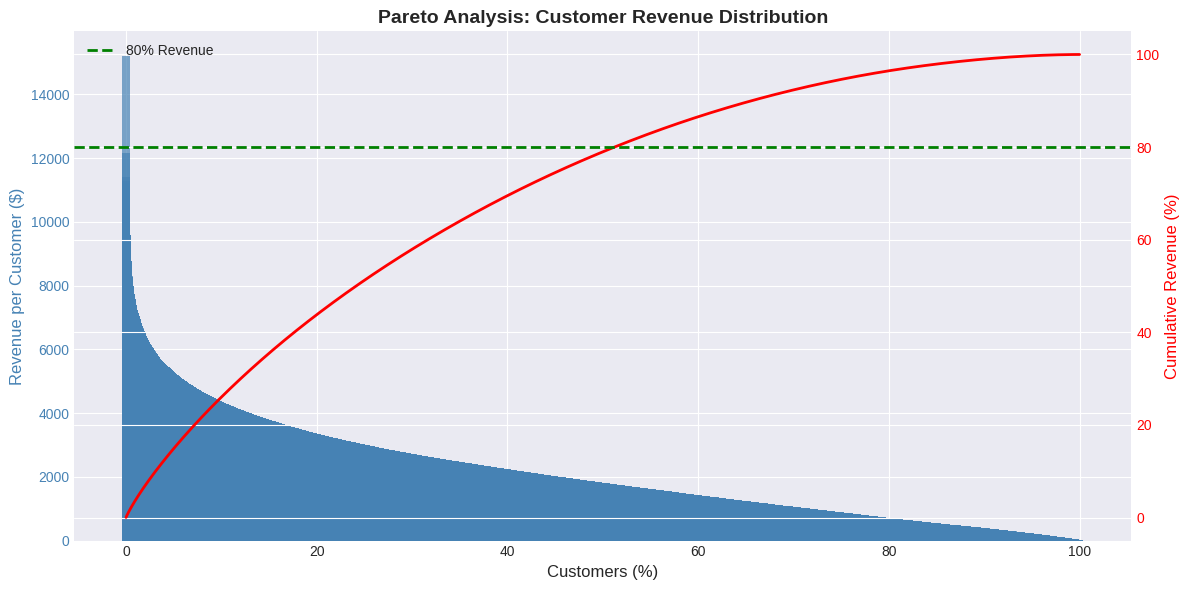


5.2 Statistical Summary by Customer Segment
--------------------------------------------------------------------------------
                    count    mean     std   min     25%     50%      75%  \
customer_segment                                                           
High-Frequency    13938.0  912.09  724.64  4.27  334.61  704.52  1334.78   
Low-Frequency     40540.0  916.66  725.05  6.19  343.13  708.97  1346.27   
Medium-Frequency  45522.0  921.56  723.99  5.59  341.16  722.12  1356.81   

                      max  
customer_segment           
High-Frequency    3491.32  
Low-Frequency     3534.98  
Medium-Frequency  3514.24  


In [13]:
print("\n" + "="*80)
print("SECTION 5: ADVANCED STATISTICAL METRICS")
print("="*80)

# Revenue concentration analysis
print("\n5.1 Revenue Concentration (Pareto Analysis)")
print("-"*80)

customer_revenue = df.groupby('customerid')['totalamount'].sum().sort_values(ascending=False)
cumulative_revenue = customer_revenue.cumsum()
cumulative_pct = (cumulative_revenue / cumulative_revenue.iloc[-1]) * 100
customers_pct = np.arange(1, len(customer_revenue) + 1) / len(customer_revenue) * 100

# Find where 80% of revenue comes from
revenue_80_idx = np.where(cumulative_pct >= 80)[0][0]
customers_80_pct = customers_pct[revenue_80_idx]

print(f"Total Customers: {len(customer_revenue):,}")
print(f"Top 20% of customers ({int(len(customer_revenue)*0.2):,}) generate:")
print(f"  {cumulative_pct[int(len(customer_revenue)*0.2)]:.2f}% of total revenue")
print(f"\n80% of revenue comes from: {customers_80_pct:.2f}% of customers")
print(f"  → Top {int(len(customer_revenue)*customers_80_pct/100):,} customers drive majority of revenue")

# Gini coefficient for revenue inequality
def gini_coefficient(x):
    sorted_x = np.sort(x)
    n = len(x)
    cumsum = np.cumsum(sorted_x)
    return (2 * np.sum((n - np.arange(1, n + 1) + 1) * sorted_x)) / (n * np.sum(sorted_x)) - (n + 1) / n

gini = gini_coefficient(customer_revenue.values)
print(f"\nGini Coefficient: {gini:.3f}")
print(f"  → 0 = perfect equality, 1 = perfect inequality")
if gini > 0.4:
    print(f"  → High inequality: Revenue is concentrated among few customers")
else:
    print(f"  → Moderate inequality: Revenue is relatively distributed")

# Visualize Pareto chart
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(customers_pct[:], customer_revenue.values[:], color='steelblue', alpha=0.7)
ax1.set_xlabel('Customers (%)', fontsize=12)
ax1.set_ylabel('Revenue per Customer ($)', fontsize=12, color='steelblue')
ax1.tick_params(axis='y', labelcolor='steelblue')

ax2 = ax1.twinx()
ax2.plot(customers_pct[:], cumulative_pct[:], color='red', linewidth=2)
ax2.axhline(y=80, color='green', linestyle='--', linewidth=2, label='80% Revenue')
ax2.set_ylabel('Cumulative Revenue (%)', fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend()

plt.title('Pareto Analysis: Customer Revenue Distribution', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Statistical summary by segment
print("\n5.2 Statistical Summary by Customer Segment")
print("-"*80)

customer_orders = df.groupby('customerid').size()
df['customer_segment'] = df['customerid'].map(lambda x: 
    'High-Frequency' if customer_orders[x] >= 5 else
    'Medium-Frequency' if customer_orders[x] >= 3 else
    'Low-Frequency')

segment_stats = df.groupby('customer_segment')['totalamount'].describe()
print(segment_stats.round(2))


# ============================================================================
# Section 6: Correlation and Covariance Analysis
# ============================================================================



SECTION 6: CORRELATION AND COVARIANCE ANALYSIS

6.1 Correlation Matrix
--------------------------------------------------------------------------------
              quantity  unitprice  discount    tax  shippingcost  totalamount
quantity         1.000      0.004    -0.000  0.438         0.020        0.595
unitprice        0.004      1.000     0.006  0.527         0.046        0.716
discount        -0.000      0.006     1.000 -0.078         0.000       -0.108
tax              0.438      0.527    -0.078  1.000         0.023        0.779
shippingcost     0.020      0.046     0.000  0.023         1.000        0.039
totalamount      0.595      0.716    -0.108  0.779         0.039        1.000

6.2 Strong Correlations (|r| > 0.5)
--------------------------------------------------------------------------------
quantity ↔ totalamount: 0.595
unitprice ↔ tax: 0.527
unitprice ↔ totalamount: 0.716
tax ↔ totalamount: 0.779

6.3 Covariance Matrix
---------------------------------------------------

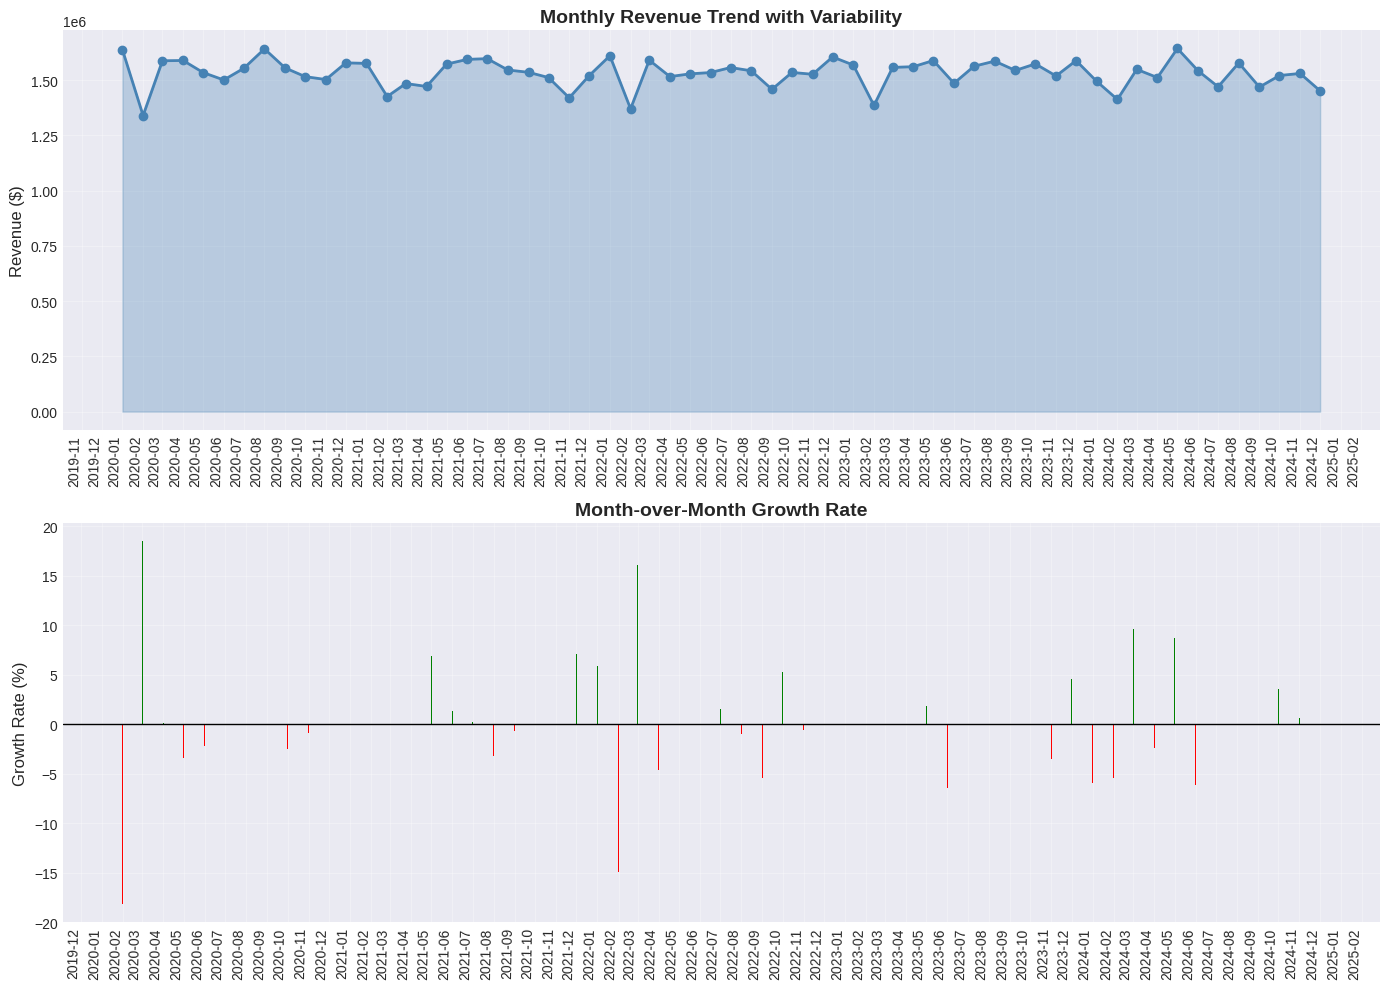


DESCRIPTIVE STATISTICS ANALYSIS COMPLETED


In [14]:
print("\n" + "="*80)
print("SECTION 6: CORRELATION AND COVARIANCE ANALYSIS")
print("="*80)

numerical_cols = ['quantity', 'unitprice', 'discount', 'tax', 'shippingcost', 'totalamount']

print("\n6.1 Correlation Matrix")
print("-"*80)
correlation_matrix = df[numerical_cols].corr()
print(correlation_matrix.round(3))

print("\n6.2 Strong Correlations (|r| > 0.5)")
print("-"*80)
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.5:
            print(f"{correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: {corr_value:.3f}")

# Covariance matrix
print("\n6.3 Covariance Matrix")
print("-"*80)
covariance_matrix = df[numerical_cols].cov()
print(covariance_matrix.round(2))

# ============================================================================
# Section 7: Time Series Statistical Analysis
# ============================================================================

print("\n" + "="*80)
print("SECTION 7: TIME SERIES STATISTICAL ANALYSIS")
print("="*80)

# Monthly statistics
df['year_month'] = df['orderdate'].dt.to_period('M')
monthly_stats = df.groupby('year_month')['totalamount'].agg(['sum', 'mean', 'std', 'count'])
monthly_stats.columns = ['Total Revenue', 'Avg Order Value', 'Std Dev', 'Order Count']

print("\n7.1 Monthly Revenue Statistics")
print("-"*80)
print(monthly_stats.tail(12).round(2))

# Calculate month-over-month growth
monthly_revenue = monthly_stats['Total Revenue']
mom_growth = monthly_revenue.pct_change() * 100

print("\n7.2 Month-over-Month Growth Rate (Last 12 Months)")
print("-"*80)
print(mom_growth.tail(12).round(2))

print(f"\nAverage MoM Growth: {mom_growth.mean():.2f}%")
print(f"Std Dev of MoM Growth: {mom_growth.std():.2f}%")
print(f"Most volatile month: {mom_growth.abs().idxmax()} ({mom_growth[mom_growth.abs().idxmax()]:.2f}%)")

# Visualize monthly trends
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Revenue trend
axes[0].plot(monthly_stats.index.to_timestamp(), monthly_stats['Total Revenue'], 
             marker='o', linewidth=2, color='steelblue')
axes[0].fill_between(monthly_stats.index.to_timestamp(), 
                      monthly_stats['Total Revenue'], 
                      alpha=0.3, color='steelblue')
axes[0].set_title('Monthly Revenue Trend with Variability', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Revenue ($)', fontsize=12)
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[0].xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every 3 months
plt.setp(axes[0].xaxis.get_majorticklabels(), rotation=89, ha='right')
axes[0].grid(alpha=0.3)

# MoM growth
axes[1].bar(mom_growth.index.to_timestamp(), mom_growth.values, 
            color=['green' if x > 0 else 'red' for x in mom_growth.values])
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=1)
axes[1].set_title('Month-over-Month Growth Rate', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Growth Rate (%)', fontsize=12)
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
axes[1].xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Show every 3 months
plt.setp(axes[1].xaxis.get_majorticklabels(), rotation=89, ha='right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("DESCRIPTIVE STATISTICS ANALYSIS COMPLETED")
print("="*80)

## Key Findings Summary:
1. Order values are right-skewed with mean > median
2. Distribution is non-normal (high kurtosis)
3. Revenue is concentrated: top 20% customers drive majority
4. No significant difference in order values across payment methods
5. Monthly revenue shows high volatility but no growth trend

### 1. Right-skewed distribution (mean USD 918 > median USD 714)
Most customers place modest orders (USD 500-800), but a few high-value orders (USD 2,000+) inflate the average. Half of all orders are below USD 714.

**Implication:** Use median, not mean, for realistic order value expectations.

### 2. High kurtosis (heavy tails)
Frequent outliers suggest diverse customer segments with different buying behaviors.

**Implication:** Segment customers by order value for targeted marketing.

### 3. Revenue concentration (Pareto principle)
Top 20% of customers drive majority of revenue. Losing key customers creates significant risk.

**Action needed:** VIP retention programs for top customers.

### 4. Payment method independence
Credit vs debit vs UPI users spend the same amount on average (p ≥ 0.05).

**Implication:** Don't incentivize specific payment types - focus marketing elsewhere.

### 5. Volatile but flat growth
Revenue bounces between USD 1.3M-1.6M monthly with no upward trend over 5 years.

**Action needed:** New strategies for growth (expand markets, new products, customer acquisition).

---

**Bottom line:** Mature, stable business with concerning revenue concentration and zero growth. Priority: retain top customers and find new growth drivers.